# Imaging Lab 2: Single Pixel Scanning

### EECS 16A: Designing Information Devices and Systems I, Fall 2021
<!--- Lily Bhattacharjee (lbhattacharjee@berkeley.edu)
      Wahid Rahman (wahid.rahman@berkeley.edu)
      Leyla Kabuli (lakabuli@berkeley.edu)
      Raghav Gupta (raghav.tech13@berkeley.edu)
---->

# Table of Contents

* [Instructions](#instructions)
* [Lab Policies](#policies)
* [Overview](#overview)
* [Task 1: Images, Vectors, and Matrices](#images)
    * [Task 1a: Working with Images](#task2a)
    * [Task 1b: Scanning Mask Matrix](#task2b)
* [Task 2: Imaging Real Pictures](#task3)
* [Checkoff](#checkoff)

<a id='instructions'></a>
## Instructions

* **Gently disinfect all commonly touched surfaces** at your lab station using the provided cleaning wipes.

* Complete this lab by filling in all of the required sections, marked with `"YOUR CODE HERE"` or `"YOUR COMMENTS HERE"`.


* When you finish, submit a checkoff request to get checked off for this lab. Be ready to answer a few questions to show your understanding of each section.


* Labs will be graded based on completion for teams of 2 students.

<a id='policies'></a>
## Lab Policies
* **YOU MUST ATTEND THE LAB SECTION YOU ARE ENROLLED IN. If you anticipate missing a section, please notify your GSI in advance.**
* **You are required to return all parts checked out at the beginning of the lab section unless told otherwise.**
* **You are free to stay for the full allotted time and hack around with the lab equipment, but please reserve the GSI's time for lab-related questions.**
* **Food and drinks are not allowed in the lab.** 
* **Clean up, turn off all equipment, and log off of computers before leaving.**

# <a id='overview'><span style='color:blue'>Overview</span></a>
<center>
<img src="images/system_diagram.svg" style="height:256px" />
</center>
This week, you will scan a real-life image pixel-by-pixel using a projector and light sensor circuit (a.k.a. <b>single pixel camera</b>) and write code in your Jupyter notebook to display the captured image. 

You will begin by checking that the circuit you built last time (with minor modifications) works and that the projector is properly connected to the computer. 

Next, you will write code to generate the "mask" patterns that the projector uses to scan the object. 

Then, you will use your generated mask matrix to photograph an image with the projector and ambient light sensor setup (seen below). Finally, you will write code to recreate the image from light sensor readings that are sent to your computer via the Launchpad.

To prevent room lighting from affecting these measurements, the projector setup is usually placed in a closed cardboard box. 

<br><br>
<center>
    <b>Cory 140 Setup</b>
<img src="images/side.png" style="height:350px" />
<br>
<b>Cory 125 Setup</b>
<img src="images/125_setup.jpg" style="height:350px" />
</center>

The single pixel imaging process would involve the following steps:
<ul>
    <li> The projector illuminates the object with a mask. </li>
    <li> The ambient light sensor detects the total amount of light reflected off the object. More light leads to more current through the sensor. </li>
    <li> The analog circuit converts the sensor's current into an output voltage. More light $\rightarrow$ higher sensor current $\rightarrow$ higher output voltage. </li>
    <li> This analog voltage is converted into a digital brightness value. </li>
</ul>    

<b>Note:</b> In the real world, we come across random irregular fluctuations while taking measurements. This is called noise. It is important to consider noise while designing any system, and this lab is no different. You will learn more about noisy imaging in the Imaging 3 lab.
</font>    

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%run scripts/test.py

<a id='images'></a>
# <span style='color:blue'>Task 1: Images, Vectors, and Matrices </span>

<a id='task2a'></a>
## <span style="color:blue">Task 1a: Working with Images</span>

<br>
    
How can we represent an image? Consider a 5x5 grayscale image, where each of the 25 pixel intensities vary in shades of gray. One way to represent this is with a 2D matrix (2D NumPy array). The values stored in this array, varying from 0 to 1, correspond to different shades of gray: the lower the pixel value, the darker the pixel, with 0 being completely black and 1 being completely white. 

For example, take the 5x5 **`gradient_image`** shown below. Starting from the top-left pixel (pixel[0,0]), each pixel becomes progressively brighter as you traverse the image row-by-row. Note that we will be using 0 indexing in lab as most programming languages (including Python) index in lists starting from 0.

<center>
<img src="images/gradient.JPG" align="center" style="height:200px" />
<figcaption>Gradient image example</figcaption>
</center>

We can create this in Python using a $5 \times 5$ NumPy 2D array called **`gradient_image`** with *linearly-spaced* floating point values from 0 to 1. The Python code to generate this is provided for you below. Take a look at the numerical 2D array and the corresponding image that is displayed by using the `imshow` function.
</font>

[[0.         0.04166667 0.08333333 0.125      0.16666667]
 [0.20833333 0.25       0.29166667 0.33333333 0.375     ]
 [0.41666667 0.45833333 0.5        0.54166667 0.58333333]
 [0.625      0.66666667 0.70833333 0.75       0.79166667]
 [0.83333333 0.875      0.91666667 0.95833333 1.        ]]


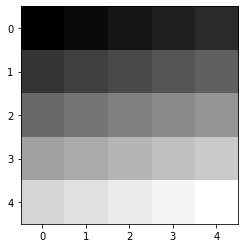

In [2]:
# A 5x5 gradient image with values from 0 to 1.
gradient_image = np.linspace(0, 1, 25).reshape([5, 5])

print(gradient_image)
plt.imshow(gradient_image, cmap = "gray", interpolation = "nearest")

**<span style="color:red">What color does 1.0 correspond to? What about 0?</span>**

White

Instead of treating our images as 2D matrices, we can "reshape" or "flatten" our images into 1-D vectors. That is, instead of having a $5 \times 5$ matrix for our image, we can represent it using a $25 \times 1$ vector. This makes it simpler for us to use the linear algebra techniques learned in class for image processing. 
    
Let's look at the 3x3 example image below (colored for illustrative purposes). How can we transform this 2D vector matrix into a 1-D column vector? 
    
Essentially, the $0$th row is flipped on its side (rotate clockwise 90 degrees), such that its left-most element is on top and its right-most element is on the bottom. The $1$st row is also flipped on its side in the same way and appended below. These steps are repeated for each subsequent row of the original 2D image until you build a $9 \times 1$ **column vector**.    

<center>
<img src="images/matrix_to_col_new.png" style="width:500px"/>
</center>

Mathematically, each pixel value in the $3 \times 3$ image is represented as a variable $p_{ij}$, where $i$ is the row and $j$ is the column associated with the pixel location. This same image represented as a 1-D column vector (called $\vec{i}$) is:

$$\vec{i} = \begin{bmatrix} p_{00} \\ p_{01} \\ p_{02} \\ p_{10} \\ p_{11} \\ p_{12} \\ p_{20} \\ p_{21} \\ p_{22} \end{bmatrix}$$    
    
The procedure described above can be used to convert any $N \times M$ 2D image into a `num_pixels` $\times 1$ **column vector**, where `num_pixels` $= N \times M$.    

**<span style="color:red">Convert the 5x5 `gradient_image` that you created above into a 25x1 column vector `gradient_image_vector` and display it. You will find the command `np.reshape` helpful. What pattern do you notice? Think about why you see this pattern.</span>**

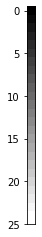

In [3]:
# TODO: Convert the 5x5 matrix into a 25x1 column vector
gradient_image_vector = np.reshape(gradient_image,(25,1))

# Display the vector
plt.imshow(gradient_image_vector, cmap = "gray", interpolation = "nearest")
plt.xticks([])
plt.yticks(np.arange(0, 30, 5))
plt.show()

<a id='task2b'></a>
## <span style="color:blue">Task 1b: Scanning Mask Matrix</span>

Next, we will create a "mask" matrix (array) to enable our simulated projector to illuminate and scan individual pixels, one at a time. This is the magic behind our virtual single pixel camera. 

If **`gradient_image_vector`** is represented by the column vector variable $\vec{i}$, the act of transforming $\vec{i}$ by a matrix $H$ into another 1D column vector $\vec{s}$ is represented mathematically as:

$$ \vec{s} = H \vec{i} $$

This matrix multiplication represents what happens when we scan an image with our virtual single pixel camera! In the context of a real-world imaging system, $H$ represents the scanning "mask matrix," whose rows are projected one-by-one onto the image we want to scan. $\vec{s}$ represents digitized readings from the analog circuit's light sensor. In the context of the simulation, each mask in $H$ will be reshaped to match the dimensions of the image, and subsequently overlaid one at a time, with only illuminated pixel measurements contributing to the corresponding mask measurement. Each element $s_k$ of $\vec{s}$ corresponds to one scan (using one row $k$ of $H$, that we refer to as $H_k$). 

Each 1D **row of $H$** represents a **mask**. But what is a mask? In the context of our virtual single pixel camera, a mask is a way to highlight certain locations in the image while hiding others during scanning. For a 3x4 image (where 3 = height, 4 = width), a mask taken from **row 0 of $H$** is represented as the $1 \times 12$ row vector below: 

$$
H_0 
= \begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\end{bmatrix}
$$

However, the mask must first be converted into its 2D form, as shown below, before it's projected over the 2D image. The mask exposes only the top-left pixel of the 2D image and hides all other pixels. Note that you can convert a 2D mask into a 1D row of $H$ by appending each of the 2D mask's rows to the right of the previous row.
<br><br>
<center>
<img src="images/black_hite.png" style="width:400px"/>
</center>
 
To expose each pixel of the 3x4 image $\vec{i}$ individually, we would need a 12x12 $H$ that has 12 masks (rows), each with a single white "exposed" pixel in a unique location. This means that **row 1 of $H$** (exposing $iv_{01}$) would look like:

$$
H_1 
= \begin{bmatrix} 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\end{bmatrix}
$$
<br><br>
<center>
<img src="images/black_white_shifted.jpg" style="width:400px"/>
</center>

The process of masking an image, then uncovering one pixel at a time, and sensing the resultant ambient light performs the matrix multiplication $\vec{s} = H \vec{i}$ in real life. This equation implies that each element of the sensor output vector $\vec{s}$ can be determined as:
    
$$s_k = H_k \vec{i}$$

Where the $k$th sensor reading is determined by the mask given by $k$th row of $H$, $H_k$. Thus, projecting the 2D representation of $H_0$ shown above onto a 3x4 image represented by the column vector $\vec{i}$ to obtain the sensor reading $s_0$ would be mathematically equivalent to:

$$
s_0 = \begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\end{bmatrix} \vec{i}
$$

**<span style="color:red">What dimensions does the mask matrix $H$ have for a 5x5 image? Why? </span>**

25 X 25

**<span style="color:red">
Create the mask matrix $H$ for a 5x5 image.</span>**

*Hint: Google the function `np.eye`.*

H mask matrix is correct


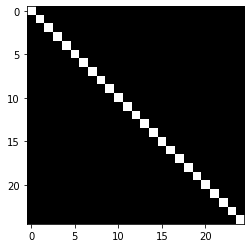

In [4]:
# TODO: Create the mask matrix `H` for scanning a 5x5 image (be careful about the dimensions!)
H = np.eye(25, 25)

# Test H for correctness
test1b_H(H)

# Display this matrix
plt.imshow(H, cmap = "gray", interpolation = "nearest")

**<span style="color:red">
Multiply the $H$ matrix with `gradient_image_vector`. Remember to use `np.dot` to do matrix multiplication and pay attention to the order of multiplcation!</span>**

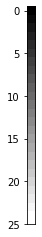

In [5]:
# TODO: Multiply `H` and `gradient_image_vector`
s = np.dot(H, gradient_image_vector)

# Display the result and compare it to `gradient_image_vector`
plt.imshow(s, cmap = "gray", interpolation = "nearest")
plt.xticks([])
plt.yticks(np.arange(0, 30, 5))
plt.show()

**<span style="color:red">Is the resultant `s` equal to `gradient_image_vector`? Why?</span>**

Yes. H is an identity matrix.

What happens when this matrix multiplication is performed? To reiterate, each row of $H$ is responsible for "illuminating," or selecting, a single pixel in the gradient image. `gradient_image_vector` was created by converting the 5x5 `gradient_image` into a 1D *column vector*. Similarly, *every row* in $H$ can be represented as a 5x5 image that, in real imaging, would be projected over `gradient_image`. 

**<span style="color:red">
Iterate through each row of the matrix $H$. *Reshape* each row into a 5x5 image, and check that each row illuminates a unique pixel of the original 5x5 image! Based on $ \vec{s} = H \vec{i} $, why are the rows of $H$ used for masking when $\vec{i}$ is a column vector?</span>**

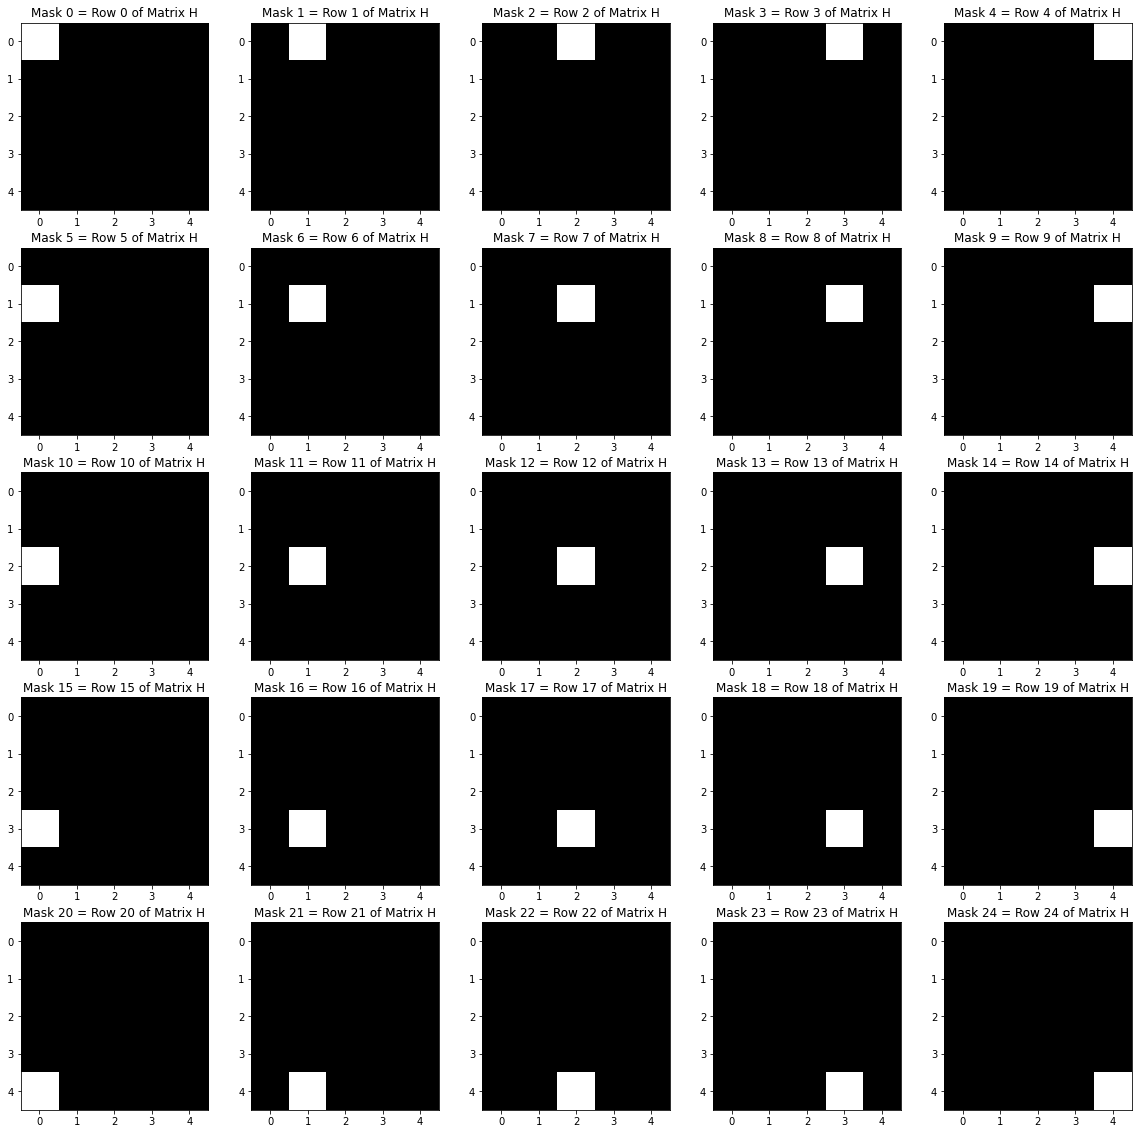

In [6]:
# Iterate through rows of matrix H and form individual masks
plt.figure(figsize = (20, 20)) 
for k in range(25):
    plt.subplot(5, 5, k + 1)
    
    mask = np.reshape(H[k], (5,5))
    
    plt.imshow(mask, cmap = "gray", interpolation = "nearest")
    plt.title("Mask " + str(k) + " = Row " + str(k) + " of Matrix H")

Each of the images above are masks. During a single scan, we project one of these masks over our image. The white pixel illuminates a particular location on the image that we want to capture, and the black pixels obscure the other parts of the image. Thus, using the rows of $H$, we gather information one pixel at a time.

Let's try to make another mask matrix, $H_{alt}$, that's a little more complicated. We want $\vec{s}$ to contain information on each pixel of the image, but in a random order. Sensing pixels in a random order and being able to reconstruct the right image is a good way to test the correctness of our imaging model. 

**<span style="color:red">
Generate $H_{alt}$ for a 5x5 image that illuminates each pixel of the image one at a time, but in a random order. Multiply $H_{alt}$ by `gradient_image_vector` to produce the new output vector $\vec{s}_{alt}$.
</span>**

<b>Hint</b>: We can use rows from the existing $H$ matrix and then shuffle their order randomly. Consider using [np.random.permutation()](https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html) for this.  The code to correctly generate `H_alt` should only require you to type 1 short line.

<b>Hint 2</b>: Here's one of many variations of $H_{alt}$ for an image of size 4x4.
<br><br>
<center>
<img src="images/H_alt_new_4x4.png" style="width:300px"/>
    <figcaption>A variation of $H_{alt}$ for a 4x4 image. </figcaption>
</center>

H_alt mask matrix is correct


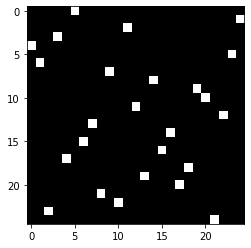

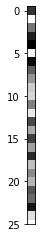

In [7]:
# TODO: Create the new mask matrix `H_alt` for a 5x5 image
H_alt = np.random.permutation(H)

# Test H_alt for correctness
test1b_H_alt(H_alt)

# Display `H_alt`
plt.figure()
plt.imshow(H_alt, cmap = "gray", interpolation = "nearest")

# TODO: Multiply `H_alt` and `gradient_image_vector`
s_alt = np.dot(H_alt, gradient_image_vector)

# Display the result `s` and compare to `gradient_image_vector`
plt.figure()
plt.imshow(s_alt, cmap = "gray", interpolation = "nearest")
plt.xticks([])
plt.yticks(np.arange(0, 30, 5))
plt.show()

Because of how we designed `H_alt`, `s_alt` is clearly different from `gradient_image_vector`. Each pixel of `gradient_image_vector` is still illuminated only once by `H_alt`, but the order in which the pixels are illuminated has changed. Therefore, we say that `s_alt` is a "scrambled" version of `gradient_image_vector`. How could we "reconstruct" $\vec{s}_{alt}$ back into the original `gradient_image_vector`? 

Recall that our original matrix $H$ was actually the **identity matrix** $I_n$. In other words, the original $\vec{s}$ was computed as:

$ \vec{s} = H \vec{i} = I_n \vec{i}$

<br />    
Using the alternate mask, $H_{alt}$, we compute the alternate output $\vec{s}_{alt}$ as:

$ \vec{s}_{alt} = H_{alt} \vec{i} $

To "reconstruct" $\vec{s}_{alt}$ back into the original `gradient_image_vector` (i.e. $\vec{i}$), we must find a matrix $M$ that multiplies $\vec{s}_{alt}$ to make the following true:

$ M \vec{s}_{alt} = \vec{i} $

i.e.

$ M H_{alt} \vec{i} = \vec{i} $

**<span style="color:red">What should M be to recover $\vec{i}$?</span>**

Inverse of H_alt

**<span style="color:red">Write code to reconstruct `gradient_image_vector` from `s_alt`.</span>**

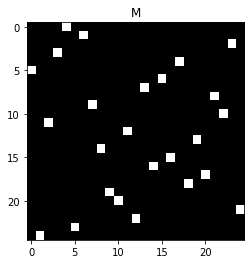

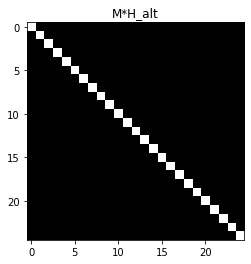

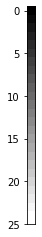

In [8]:
# TODO: Reconstruct `gradient_image_vector`
M = np.linalg.inv(H_alt)
gradient_image_vector_reconstruct = np.dot(M,s_alt)

# Display M
plt.figure()
plt.imshow(M, cmap = "gray", interpolation = "nearest")
plt.title("M")
plt.show()

# Display M*H_alt
plt.figure()
plt.imshow(np.dot(M,H_alt), cmap = "gray", interpolation = "nearest")
plt.title("M*H_alt")
plt.show()

# Display the result
plt.imshow(gradient_image_vector_reconstruct, cmap = "gray", interpolation = "nearest")
plt.xticks([])
plt.yticks(np.arange(0, 30, 5))
plt.show()

<a id='task3'></a>
## <span style="color:blue">Imaging Real Pictures</span>

Finally, we will use our two matrices to image a real picture. Because our picture is fairly large, we want each individual mask to have dimensions 30x40 (i.e. height = 30, width = 40) to match the 4:3 (W:H) aspect ratio of the projector. Think about how big the mask matrix was for the 5x5 example. How big must it be for a 30x40 picture?

**<span style="color:red">
Recreate both the $H$ and $H_{Alt}$ masks to match these new dimensions. </span>**

In [9]:
%run scripts/test.py

<Figure size 432x288 with 0 Axes>

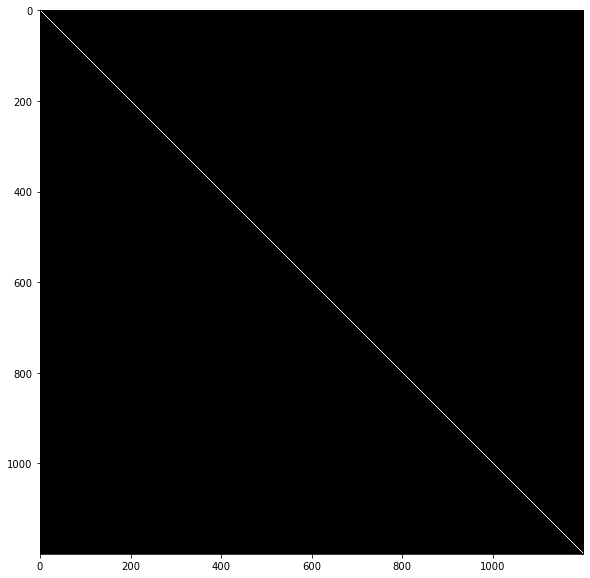

In [10]:
# TODO: Recreate `H`
H = np.eye(1200, 1200)
plt.figure(figsize = (10, 10))
plt.imshow(H, cmap = 'gray', interpolation="nearest")

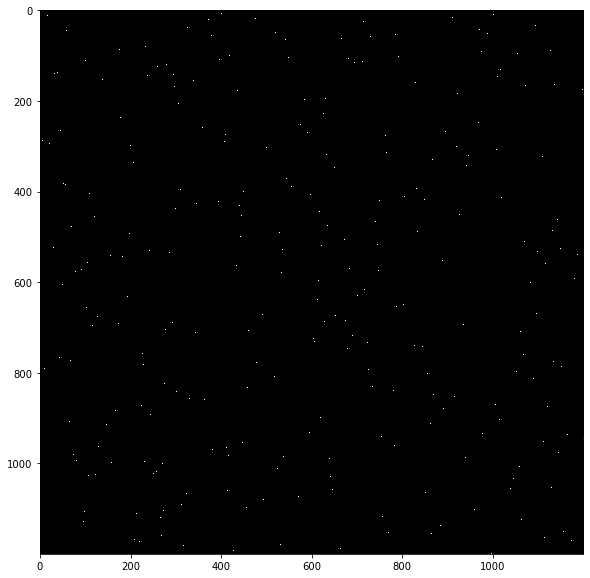

In [11]:
# TODO: Recreate `H_Alt`      
H_Alt = np.random.permutation(H)
plt.figure(figsize = (10, 10))
plt.imshow(H_Alt, cmap = 'gray', interpolation="nearest")

Let's make sure that the two matrices we made are invertible and the correct size. Run the code block below to invert the matrices and test dimensions - if any of the lines fail, it means the code used to generate either matrix resulted in a incorrect size or non-invertible, linearly dependent matrix, which is incorrect. 

In [12]:
test_masks_img2(H, H_Alt)

H and H_Alt are the correct dimension and are both invertible. Proceed to the next step


Our mask matrices must be saved as files before they can be used to perform real imaging. The files are read by our imaging script, as seen below. 

**<span style="color:red">Run the cell below to save `H` and `H_Alt`!</span>**

In [13]:
np.save('H.npy', H)
np.save('H_Alt.npy', H_Alt)

##  <span style="color:red">**IMPORTANT**</span>: <a id ='setup'><span style = "color: blue">Hardware Setup</span></a>

# Please follow instructions here ( [Cory 140](eecs16a_imaging_setup_140.pdf) [Cory 125](eecs16a_imaging_setup_125.pdf) ) *verbatim* to get consistent results. Having a good setup will make taking the picture much easier and cleaner! The cardboard box can be found in the top left of your station.



## Once you are done with the setup, call over either a TA or an ASE to have them check over your setup to make sure it is correct.

Now, we need an object to take a picture of. There are index cards and markers at the GSI desk; **<span style="color:red">take an index card and draw something on its blank (no lines) side. Place this index card inside the box so that the projector can project onto it</span>** (see the Overview image). 

**<span style="color:green">Cory 140 Setup</span>**: Insert the index card into the slot at the far end of the stand. As in the setup instructions linked above, place your index card so that your image is upside down. This will ensure that the scan will end up right side up, since your projector is also placed upside down.

**<span style="color:blue">Cory 125 Setup</span>**: You'll need to tape the index card to the side of the box that the projector is projecting onto. 

Tape is on the TA desk; do not take the whole dispenser.

**<span style="color:red">Double check that you've done the following before proceeding:</span>**

* Upload `AnalogReadSerial` to the Launchpad.

* Close out of the Energia Serial Monitor.

* Make sure that the ambient light sensor is aimed at the center of the index card! The legs should not be touching.

* Seal the imaging system inside the box to keep ambient light out during scanning. If the holes for cables are too big, try to have them face a solid, unmoving object that can block out light.

**<span style="color:red">You will then run the `capture_image.py` script below that projects mask patterns onto your image based on the $H$ matrix that you designate. This script controls the scanning process.</span>** 

In the code block below, the `--mask` tag points to the file (including the .npy extension) associated with the mask matrix you want to use. The `--out` tag tells the script where you want to save the column vector sensor data. (The "out" file name doesn't include the npy extension, as it's automatically appended. Additionally, info about the capture settings, like projector brightness, is also appended to the file name. We'll take care of this for you.)

When running **`capture_image.py`**, a new icon shaped like a white web will appear in the taskbar. The window depicting our masks will appear on the projector's screen. *You can confirm this by looking into the box. (Don't forget to close the box when you're done checking!)*

Before scanning, you will be prompted to specify the **COM port used by the Launchpad and the display associated with the projector.** 

**Select the COM port associated with UART1 (previously accessed in the Energia Serial Monitor and found using the Device Manager) and the 1280x720 projector screen.** Note that you want to specify the **index** of your choice i.e. for `2) 1280 x 720`, specify 2. **<span style="color:red">Make sure that you selected the correct COM port!</span>**

`capture_image.py` iterates over the rows of the $H$ matrix you made. These rows are translated, one-by-one, into real masks projected onto the screen. Light sensor readings are taken for each mask. At the start of the scan, you'll see a series of `Loc: # Data: #` printed to the output below. `Loc` corresponds to the index $k$ of the current sensor reading (and likewise current row of H). `Data` corresponds to the actual digitized value obtained from the light sensor. This "debug" information is printed consecutively for the first few/last few sensor outputs. Otherwise, this info is printed when `k % 100 = 0` (every 100 scans). 

Don't worry about messages like `Time delta between captures in s: #`. This is printed a lot because the lab computers are slow. Make sure you followed the hardware setup near the beginning - restart your MSP by unplugging and replugging it in after programming it.

The whole scanning process should take roughly 3 minutes. 

Running the code block below will start your scan - **don't** click on the window popup.


EE16A Imaging Lab

Serial timeout in ms: 150
Sleep time in ms: 120
Projector brightness scale in percent: 100
FPS: 40
Image width: 40
Image height: 30
Mask file: H.npy 

Checking serial connections...
Available serial ports:
1) COM1
2) COM7
3) COM26
4) COM27
Select the port to use: 3

Detected 2 screens
Currently displaying on screen 1
1) 1920 x 1200
2) 1280 x 720
Select the projector screen: 2

Period in msecs:  25.0

Starting scan 0... 

Loc: 0 Data: 23 
Time delta between captures in s: 0.1597144603729248
Loc: 1 Data: 23 
Time delta between captures in s: 0.15035295486450195
Loc: 2 Data: 24 
Time delta between captures in s: 0.15351295471191406
Loc: 3 Data: 24 
Time delta between captures in s: 0.16716909408569336
Loc: 4 Data: 23 
Loc: 5 Data: 24 
Loc: 6 Data: 24 
Loc: 7 Data: 24 
Loc: 8 Data: 24 
Loc: 9 Data: 24 
Time delta between captures in s: 0.1676802635192871
Time delta between captures in s: 0.1672682762145996
Time delta between captures in s: 0.16755270957946777
Time delta

Time delta between captures in s: 0.1671895980834961
Time delta between captures in s: 0.16793060302734375
Time delta between captures in s: 0.16771769523620605
Time delta between captures in s: 0.16469526290893555
Time delta between captures in s: 0.1676948070526123
Time delta between captures in s: 0.1626133918762207
Time delta between captures in s: 0.1672055721282959
Time delta between captures in s: 0.1677687168121338
Time delta between captures in s: 0.16319799423217773
Time delta between captures in s: 0.16730117797851562
Time delta between captures in s: 0.16402149200439453
Time delta between captures in s: 0.16541028022766113
Time delta between captures in s: 0.1671745777130127
Time delta between captures in s: 0.1671905517578125
Loc: 900 Data: 20 
Time delta between captures in s: 0.16728711128234863
Time delta between captures in s: 0.1628587245941162
Time delta between captures in s: 0.16242170333862305
Time delta between captures in s: 0.16232037544250488
Time delta betwee

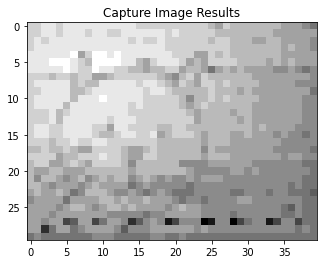

Min sensor reading: 14.0
Max sensor reading: 25.0


<Figure size 432x288 with 0 Axes>

In [2]:
# Import necessary libraries (so you don't have to start from the top)
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats
%matplotlib inline

%run capture_image.py --mask H.npy --out sensor_readingsH

**<span style="color:red">Not getting a good picture?</span>**

If you selected the incorrect COM port, a lot more "debug" lines will be dumped. You might notice `Data: -1` or `Losing data! Consider increasing your timeout!` messages. Once you see these messages, **stop** running that code block, **save** your Jupyter notebook, then **close the ipython notebook in terminal (Ctrl+C twice) and re-open it** (alternately, you can save and restart your kernel). You'll lose any saved variables (not output images), but everything you need has been saved to a file. Rerun the following code block again, but **make sure you select the right COM port**. 

After the sensor readings have been captured, load the sensor reading vector into the cell below. Once again, here is the equation relating $H$, the sensor reading column vector $\vec{s}$, and the image column vector $\vec{i}$:

$$\vec{s} = H \vec{i}$$

**<span style="color:red">Recreate the image from the sensor readings obtained with `H`.</span>**

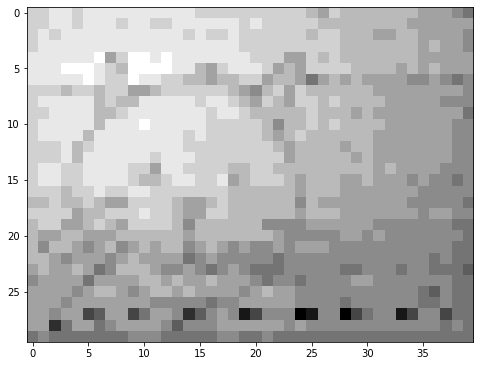

In [3]:
# Sensor readings
sr = np.load('sensor_readingsH_100_0.npy')
H = np.load('H.npy')

# TODO: Create the image vector from `H` and `sr`
# Hint: Because `H` is a special matrix, technically you do not need to perform any matrix operations
iv = sr

img = np.reshape(iv, (30, 40))
plt.figure(figsize = (8, 8))
plt.imshow(img, cmap = 'gray', interpolation="nearest")

Congratulations! You have imaged your first image using your single pixel camera! 

**<span style="color:red">
Does your recreated image match the real image? What are some problems you notice? 
</span>**

Here is an example of a picture we took using this setup:

<center>
<img src="images/ee16a_picture.png"/>
</center>

**<span style="color:red">Next, use the second mask `H_Alt` for imaging. Can you repeat the same reconstruction procedure just by replacing $H$ with $H_{Alt}$? Why or why not?</span>**

Run `capture_image.py` again (taking the same precautions as above) to collect sensor readings. Make sure to run it from the code block below to point the script to `H_Alt`. Then reconstruct the image.


EE16A Imaging Lab

Serial timeout in ms: 150
Sleep time in ms: 120
Projector brightness scale in percent: 100
FPS: 40
Image width: 40
Image height: 30
Mask file: H_Alt.npy 

Checking serial connections...
Available serial ports:
1) COM1
2) COM7
3) COM26
4) COM27
Select the port to use: 3

Detected 2 screens
Currently displaying on screen 1
1) 1920 x 1200
2) 1280 x 720
Select the projector screen: 2

Period in msecs:  25.0

Starting scan 0... 

Loc: 0 Data: 23 
Time delta between captures in s: 0.15918302536010742
Loc: 1 Data: 24 
Time delta between captures in s: 0.14984464645385742
Loc: 2 Data: 22 
Time delta between captures in s: 0.16220331192016602
Loc: 3 Data: 22 
Time delta between captures in s: 0.15962672233581543
Loc: 4 Data: 20 
Loc: 5 Data: 23 
Loc: 6 Data: 22 
Loc: 7 Data: 23 
Loc: 8 Data: 24 
Loc: 9 Data: 21 
Time delta between captures in s: 0.1675422191619873
Time delta between captures in s: 0.16897177696228027
Time delta between captures in s: 0.16718769073486328
Time

Time delta between captures in s: 0.16246962547302246
Time delta between captures in s: 0.16736102104187012
Time delta between captures in s: 0.16718697547912598
Time delta between captures in s: 0.16270780563354492
Time delta between captures in s: 0.16767454147338867
Time delta between captures in s: 0.16389155387878418
Time delta between captures in s: 0.16733193397521973
Time delta between captures in s: 0.16704201698303223
Time delta between captures in s: 0.16570162773132324
Time delta between captures in s: 0.16718029975891113
Loc: 800 Data: 21 
Time delta between captures in s: 0.1644282341003418
Time delta between captures in s: 0.16275978088378906
Time delta between captures in s: 0.16288208961486816
Time delta between captures in s: 0.1671898365020752
Time delta between captures in s: 0.16391968727111816
Time delta between captures in s: 0.16440701484680176
Time delta between captures in s: 0.1636815071105957
Time delta between captures in s: 0.16283535957336426
Time delta b

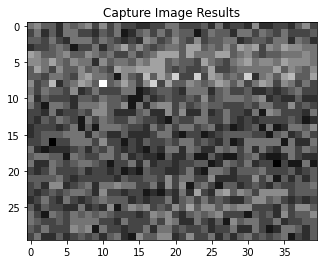

Min sensor reading: 18.0
Max sensor reading: 29.0


<Figure size 432x288 with 0 Axes>

In [4]:
# Import necessary libraries (so you don't have to start from the top)
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats
%matplotlib inline

%run capture_image.py --mask H_Alt.npy --out sensor_readingsHAlt

Observe your sensor reading. Since we're scanning pixels of the image in a random order, it should be a scrambled version of the image.

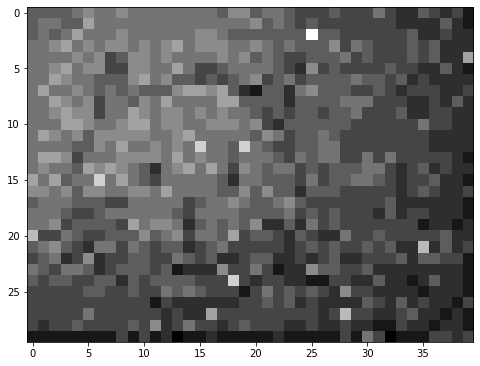

In [5]:
# Sensor readings
sr = np.load('sensor_readingsHAlt_100_0.npy')
H_Alt = np.load('H_Alt.npy')

# TODO: Create the image vector from `H_Alt` and `sr`
# Hint: You need to perform a matrix operation before multiplying
iv = np.dot(np.linalg.inv(H_Alt),sr)

img = np.reshape(iv, (30, 40))
plt.figure(figsize = (8, 8))
plt.imshow(img, cmap = 'gray', interpolation="nearest")

**<span style="color:red">The sensor reading is a scrambled version of the image. Were you able to reconstruct the image correctly? How did it get "unscrambled"?  </span>**

Yes

You are done for the week! Save your code and circuit for next lab, where you will illuminate multiple pixels per mask!

## **<span style="color:red"> Do not take apart your setup before being checked off. </span>** 
**Afterwards, you may take the Launchpad and circuit kit with you. Remember to bring it back next week!**

**Please ensure you've placed the entire imaging setup box with the following items back on the station shelf:**

1. Pico Projector
1. Power Adapter
1. Long micro USB cable
1. Wooden Stand

<a id='checkoff'></a>
## Checkoff
When you are ready to get checked off,
1. Fill out the checkoff google form. **[Checkoff Form](https://docs.google.com/forms/d/e/1FAIpQLSeq9w_gvQKS37hUXgTDtiYhu9gNmu5OFzglIYAF4nfXQc5mOA/viewform?usp=sf_link)**
2. Submit a **checkoff** request on the lab queue. **[Checkoff queue](https://lab.eecs16a.org)** Only one person from your group should submit the queue request, but everyone must submit their own google form. 

Your GSI or a Lab Assistant will join you when they are available and go through some checkoff questions with your group. They will go through the checkoff list in order. Please be patient!


#### Post-checkoff Clean Up: (this applies to each week's lab)
1. Pack away your launchpad and lab kit materials to bring home  - make a note to bring them back next week!
2. Throw away any trash at your station
3. Return the wires from the back walls
4. SIGN OUT of the computers - DO NOT SHUT DOWN
5. Check that other machines at your lab station are powered off